# Ainu Speech Collection Identification (Adapted Model)

Ainu oral narrative sample sets:
- asai_take_stories
- kimura_kimi_stories
- oda_ito_stories

Goal: Identify which collection (proxy for storyteller/source) an unseen audio clip belongs to using CNN-based acoustic features.

(Adapted from prior Japanese singer recognition notebook; all references changed to Ainu collections.)

### Simplification & Adaptation Summary
- Removed bulk NPZ export & augmentation variants from the original singer workflow.
- Replaced dataset building with on-the-fly mel extraction + light optional augmentation.
- Unified sampling rate to 16kHz for speech consistency.
- Added inference helper for collection prediction.
- Legacy analysis / advanced result blocks preserved only where easily reusable; heavy singer-specific analytics marked as legacy.

Next potential improvements:
1. Confusion matrix & per-collection precision/recall.
2. Feature caching (disk or memmap) for faster epochs.
3. Optional pre-trained embedding front-end (e.g., wav2vec2) + linear head.
4. Integrate transcripts later for joint identification + CTC recognition.


In [54]:
# 1. Imports & Config (with per-collection sampling)
import os, sys, math, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from tqdm import tqdm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

DATA_ROOT = Path('..')/ 'data' / 'samples'
AINU_DIRS = [
    DATA_ROOT / 'asai_take_stories',
    DATA_ROOT / 'kimura_kimi_stories',
    DATA_ROOT / 'oda_ito_stories'
 ]
AUDIO_EXT = {'.wav', '.flac', '.mp3'}

# Data usage & balancing configuration
DATA_USAGE_CFG = {
    'max_per_collection': None,      # None -> use ALL available files
    'deterministic_shuffle': True,
    'balance_strategy': 'weighted',  # 'none' | 'weighted'
    'min_samples_per_class': 1       # safety floor
}
print('Data usage config:', DATA_USAGE_CFG)

def list_audio(p: Path):
    return [f for f in p.rglob('*') if f.suffix.lower() in AUDIO_EXT]

rows = []
for d in AINU_DIRS:
    if not d.exists():
        print('[WARN] missing dir:', d)
        continue
    files = list_audio(d)
    if not files:
        continue
    files_sorted = sorted(files)
    if DATA_USAGE_CFG['deterministic_shuffle']:
        random.Random(SEED).shuffle(files_sorted)
    limit = DATA_USAGE_CFG['max_per_collection']
    subset = files_sorted if limit is None else files_sorted[:limit]
    if limit is not None and len(files) > limit:
        print(f'[Info] {d.name}: using {len(subset)}/{len(files)} files (limited).')
    for fp in subset:
        rows.append({'file_path': str(fp.resolve()), 'collection': d.name})
meta_df = pd.DataFrame(rows)
print('Total files indexed:', len(meta_df))
if not meta_df.empty:
    print(meta_df.groupby('collection').size())

Device: cuda
Data usage config: {'max_per_collection': None, 'deterministic_shuffle': True, 'balance_strategy': 'weighted', 'min_samples_per_class': 1}
Total files indexed: 2854
collection
asai_take_stories      2816
kimura_kimi_stories      23
oda_ito_stories          15
dtype: int64


In [55]:
# Performance / DataLoader configuration
DATA_LOADER_CFG = {
    'num_workers': 4,          # Increase if CPU cores available
    'pin_memory': True,        # Faster host->GPU transfer
    'prefetch_factor': 2,      # Each worker prefetch batches
    'persistent_workers': True,# Keep workers alive between epochs
    'cache_warm': True,        # Pre-build feature cache before training
    'log_interval': 50,        # Batches between progress logs
    'cudnn_benchmark': True    # Enable CuDNN autotuner for constant shapes
}

# Optionally adapt num_workers automatically
import multiprocessing, torch
if DATA_LOADER_CFG['num_workers'] == 'auto':
    DATA_LOADER_CFG['num_workers'] = max(2, multiprocessing.cpu_count()//2)

if torch.cuda.is_available() and DATA_LOADER_CFG.get('cudnn_benchmark'):
    torch.backends.cudnn.benchmark = True

print('Data loader performance config:', DATA_LOADER_CFG)

Data loader performance config: {'num_workers': 4, 'pin_memory': True, 'prefetch_factor': 2, 'persistent_workers': True, 'cache_warm': True, 'log_interval': 50, 'cudnn_benchmark': True}


### 1a. Audio Loading Robustness & Validation

Some WAV files fail to open via libsndfile ("Format not recognised"). This can happen if:
- The file header is corrupt or mislabeled (e.g., MP3 renamed to .wav)
- Uses a codec not compiled into the local libsndfile
- Partial / zero-byte download

Mitigations implemented below:
1. `safe_load` with multi-backend fallback (librosa -> soundfile -> audioread/ffmpeg)
2. Validation pass to drop unreadable or empty files before splitting
3. Optional environment toggle (`SKIP_AUDIO_VALIDATION=1`) to skip the scan
4. Summary report + JSON log of failures (`audio_load_failures.json`)

If many failures occur, re-encode originals using ffmpeg, e.g.:
```
ffmpeg -y -i input_original.wav -ac 1 -ar 16000 -c:a pcm_s16le fixed.wav
```

Proceeding to define the robust loader and clean the file list.

In [56]:
# 2. Train/Test Split & Label Mapping
from sklearn.model_selection import train_test_split

if meta_df.empty:
    train_files, test_files = [], []
    collection_to_id = {}
else:
    collections = sorted(meta_df['collection'].unique())
    collection_to_id = {c:i for i,c in enumerate(collections)}
    meta_df['label'] = meta_df['collection'].map(collection_to_id)
    train_df, test_df = train_test_split(meta_df, test_size=0.25, random_state=SEED, stratify=meta_df['label'])
    train_files = train_df.to_dict('records')
    test_files = test_df.to_dict('records')
    print('Collections:', collections)
    print('Train/Test sizes:', len(train_files), len(test_files))

Collections: ['asai_take_stories', 'kimura_kimi_stories', 'oda_ito_stories']
Train/Test sizes: 2140 714


In [57]:
# 2a. Robust audio loader and validation scan (run before split if failures seen later)
import os, json, warnings, io
from typing import Tuple, Optional

VALIDATION_SAMPLE_LIMIT = None  # set int for faster debugging
TARGET_SR = 16000

load_failures = []

def safe_load(path: str, sr: int = TARGET_SR, mono: bool = True) -> Tuple[Optional[np.ndarray], Optional[int]]:
    """Attempt to load audio with multiple strategies.
    Returns (y, sr) or (None, None) if all strategies fail."""
    # Strategy 1: librosa (soundfile backend then audioread fallback internally)
    try:
        y, s = librosa.load(path, sr=sr, mono=mono)
        if y is not None and len(y) > 0:
            return y, s
    except Exception as e:
        pass
    # Strategy 2: direct soundfile (raw) if available
    try:
        import soundfile as sf
        with sf.SoundFile(path) as f:
            data = f.read(always_2d=False)
            s = f.samplerate
        if data is not None and data.size > 0:
            if mono and data.ndim > 1:
                data = np.mean(data, axis=0)
            if s != sr:
                data = librosa.resample(data, orig_sr=s, target_sr=sr)
                s = sr
            return data.astype(np.float32), s
    except Exception:
        pass
    # Strategy 3: audioread manual decode
    try:
        import audioread
        import numpy as np
        with audioread.audio_open(path) as af:
            raw = b''.join([buf for buf in af])
            # Convert bytes to np.int16 assuming 16-bit PCM; if not PCM this may still fail
            audio16 = np.frombuffer(raw, dtype=np.int16)
            if audio16.size == 0:
                raise ValueError('Empty decode')
            y = audio16.astype(np.float32) / 32768.0
            if mono and af.channels > 1:
                y = y.reshape(-1, af.channels).mean(axis=1)
            if af.samplerate != sr:
                y = librosa.resample(y, orig_sr=af.samplerate, target_sr=sr)
            return y, sr
    except Exception:
        pass
    return None, None

# Validation pass (skip if env flag set)
if os.environ.get('SKIP_AUDIO_VALIDATION','0') != '1' and not meta_df.empty:
    valid_rows = []
    for i, row in meta_df.iterrows():
        if VALIDATION_SAMPLE_LIMIT and i >= VALIDATION_SAMPLE_LIMIT:
            break
        fp = row['file_path']
        y, s = safe_load(fp)
        if y is None or len(y) == 0:
            load_failures.append(fp)
        else:
            valid_rows.append(row)
    if load_failures:
        print(f"[Audio Validation] {len(load_failures)} / {len(meta_df)} files failed to load and will be dropped.")
        with open('audio_load_failures.json','w') as f:
            json.dump(load_failures, f, indent=2)
        meta_df = pd.DataFrame(valid_rows)
    else:
        print('[Audio Validation] All files loaded successfully.')
else:
    print('[Audio Validation] Skipped by flag or empty dataset.')

[Audio Validation] 2 / 2854 files failed to load and will be dropped.


Sample file: /home/nk21137/OneDrive/5years/graduation_research/ainu/data/samples/asai_take_stories/At49_065.wav
Wave shape: (42725,) Mel shape: (128, 167)


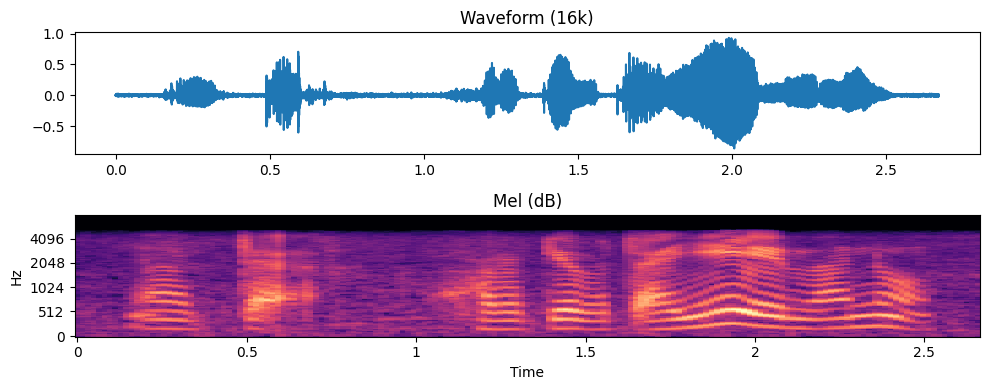

In [58]:
# 3. Quick Wave & Mel Visualization (first available file)
import librosa.display

if not meta_df.empty:
    sample_path = meta_df.iloc[0]['file_path']
    y, sr = librosa.load(sample_path, sr=16000, mono=True)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    print('Sample file:', sample_path)
    print('Wave shape:', y.shape, 'Mel shape:', mel_db.shape)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4), sharex=False)
    ax1.plot(np.linspace(0, len(y)/sr, num=len(y)), y)
    ax1.set_title('Waveform (16k)')
    librosa.display.specshow(mel_db, sr=sr, hop_length=256, y_axis='mel', x_axis='time', ax=ax2)
    ax2.set_title('Mel (dB)')
    fig.tight_layout()
else:
    print('No audio files found for visualization.')

In [59]:
# 4. Simple Augmentation Helpers (optional)

def add_noise(y, std=0.003):
    if std<=0: return y
    return y + np.random.randn(*y.shape)*std

def time_shift(y, max_frac=0.2):
    if max_frac<=0: return y
    shift = int(len(y)*random.uniform(-max_frac, max_frac))
    return np.roll(y, shift)

AUG_CFG = {'noise_std':0.002, 'time_shift':0.1, 'enable': False}
print('Augmentation config:', AUG_CFG)

Augmentation config: {'noise_std': 0.002, 'time_shift': 0.1, 'enable': False}


In [60]:
# 4b. Improvement Configuration (applied after basic helpers)
IMPROVE_CFG = {
    'random_crop_frames': 800,      # < TARGET_FRAMES; None to disable
    'random_crop_jitter': 20,        # +/- jitter frames when sampling start
    'specaug_time_masks': 1,         # number of time masks
    'specaug_time_max_frac': 0.10,   # max fraction of frames per mask
    'specaug_freq_masks': 1,         # number of frequency masks
    'specaug_freq_max_bins': 16,     # max mel bins per frequency mask
    'use_delta': True,               # add Δ (and ΔΔ) channels
    'use_delta_delta': True,         # add ΔΔ channel (if use_delta True)
    'global_norm': True,             # use global mean/std instead of per-sample
    'augment_prob': 0.8,             # probability to apply SpecAugment on a training sample
    'enable': True
}
print('Improvement config:', IMPROVE_CFG)

Improvement config: {'random_crop_frames': 800, 'random_crop_jitter': 20, 'specaug_time_masks': 1, 'specaug_time_max_frac': 0.1, 'specaug_freq_masks': 1, 'specaug_freq_max_bins': 16, 'use_delta': True, 'use_delta_delta': True, 'global_norm': True, 'augment_prob': 0.8, 'enable': True}


In [61]:
# Check class distribution in test set using test_df
num_classes = len(collection_to_id)
a = np.zeros(num_classes, dtype=int)
for c in test_df['label']:
    a[c] += 1
print(f"Test set class distribution (all classes): {a}")
print(f"Number of classes: {num_classes}")

Test set class distribution (all classes): [704   6   4]
Number of classes: 3


In [ ]:
# 5. Build In-Memory Mel Tensors (robust + improvements + caching) + Dataset definition (restored)
import hashlib, numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import librosa

TARGET_N_MELS = 128
TARGET_FRAMES = 1000
FAILED_MEL_FILES = []
CACHE_HITS = globals().get('CACHE_HITS', 0)
CACHE_MISSES = globals().get('CACHE_MISSES', 0)
RESIZED_CACHED = globals().get('RESIZED_CACHED', 0)

# Ensure CACHE_CFG / IMPROVE_CFG exist (already defined earlier, defensive only)
CACHE_CFG = globals().get('CACHE_CFG', {'enable': False})
IMPROVE_CFG = globals().get('IMPROVE_CFG', {'enable': False})

from pathlib import Path
_cache_root = Path(CACHE_CFG.get('cache_dir', '_mel_cache'))
if CACHE_CFG.get('enable'):
    _cache_root.mkdir(exist_ok=True, parents=True)

def _cache_path(path_str: str):
    if not CACHE_CFG.get('enable'):
        return None
    h = hashlib.md5(path_str.encode('utf-8')).hexdigest()
    ext = '.npy' if not CACHE_CFG.get('compress') else '.npz'
    return _cache_root / f'{h}{ext}'

GLOBAL_MEL_MEAN = globals().get('GLOBAL_MEL_MEAN')
GLOBAL_MEL_STD = globals().get('GLOBAL_MEL_STD')

def _apply_global_norm(mel_db):
    if IMPROVE_CFG.get('global_norm') and GLOBAL_MEL_MEAN is not None and GLOBAL_MEL_STD is not None:
        return (mel_db - GLOBAL_MEL_MEAN[:, None]) / (GLOBAL_MEL_STD[:, None] + 1e-6)
    return (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

def _random_crop_train(mel_db):
    crop_len = IMPROVE_CFG.get('random_crop_frames')
    if not (IMPROVE_CFG.get('enable') and crop_len):
        return mel_db
    if mel_db.shape[1] < crop_len:
        mel_db = np.pad(mel_db, ((0,0),(0, crop_len - mel_db.shape[1])), mode='constant')
    if mel_db.shape[1] == crop_len:
        return mel_db
    max_start = mel_db.shape[1] - crop_len
    jitter = IMPROVE_CFG.get('random_crop_jitter', 0)
    start = np.random.randint(0, max_start + 1)
    if jitter>0:
        start = max(0, min(max_start, start + np.random.randint(-jitter, jitter+1)))
    return mel_db[:, start:start+crop_len]

def _center_crop_eval(mel_db):
    crop_len = IMPROVE_CFG.get('random_crop_frames')
    if not (IMPROVE_CFG.get('enable') and crop_len):
        return mel_db
    if mel_db.shape[1] < crop_len:
        mel_db = np.pad(mel_db, ((0,0),(0, crop_len - mel_db.shape[1])), mode='constant')
    if mel_db.shape[1] == crop_len:
        return mel_db
    total = mel_db.shape[1]
    start = (total - crop_len)//2
    return mel_db[:, start:start+crop_len]

def _spec_augment(mel_tensor):
    if not IMPROVE_CFG.get('enable'):
        return mel_tensor
    if np.random.rand() > IMPROVE_CFG.get('augment_prob', 1.0):
        return mel_tensor
    C, M, T = mel_tensor.shape
    for _ in range(IMPROVE_CFG.get('specaug_time_masks', 0)):
        t_max = int(T * IMPROVE_CFG.get('specaug_time_max_frac', 0.0))
        if t_max>0:
            t_len = np.random.randint(1, t_max+1)
            t_start = np.random.randint(0, max(1, T - t_len + 1))
            mel_tensor[:, :, t_start:t_start+t_len] = 0.0
    for _ in range(IMPROVE_CFG.get('specaug_freq_masks', 0)):
        f_max = IMPROVE_CFG.get('specaug_freq_max_bins', 0)
        if f_max>0:
            f_len = np.random.randint(1, f_max+1)
            f_start = np.random.randint(0, max(1, M - f_len + 1))
            mel_tensor[:, f_start:f_start+f_len, :] = 0.0
    return mel_tensor

def _add_deltas(mel_db):
    if not IMPROVE_CFG.get('enable') or not IMPROVE_CFG.get('use_delta'):
        return mel_db[None, ...]
    delta = librosa.feature.delta(mel_db)
    if IMPROVE_CFG.get('use_delta_delta'):
        delta2 = librosa.feature.delta(mel_db, order=2)
        return np.stack([mel_db, delta, delta2], axis=0)
    return np.stack([mel_db, delta], axis=0)

def wav_to_mel_tensor(path: str, train_mode: bool=True):
    global CACHE_HITS, CACHE_MISSES, RESIZED_CACHED
    y, sr = safe_load(path, sr=16000, mono=True)
    if y is None or len(y)==0:
        FAILED_MEL_FILES.append(path)
        mel_db = np.zeros((TARGET_N_MELS, TARGET_FRAMES), dtype=np.float32)
    else:
        cache_file = _cache_path(path)
        base_mel_db = None
        if cache_file and cache_file.exists() and not CACHE_CFG.get('recompute'):
            try:
                if CACHE_CFG.get('compress'):
                    data = np.load(cache_file)
                    base_mel_db = data['mel']
                else:
                    base_mel_db = np.load(cache_file)
                CACHE_HITS += 1
            except Exception:
                base_mel_db = None
        if base_mel_db is None:
            mel = librosa.feature.melspectrogram(y=y, sr=16000, n_fft=1024, hop_length=256, n_mels=TARGET_N_MELS)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            if mel_db.shape[1] > TARGET_FRAMES:
                mel_db = mel_db[:, :TARGET_FRAMES]
            elif mel_db.shape[1] < TARGET_FRAMES:
                mel_db = np.pad(mel_db, ((0,0),(0, TARGET_FRAMES - mel_db.shape[1])), mode='constant')
            base_mel_db = mel_db.astype(np.float32)
            if cache_file:
                try:
                    if CACHE_CFG.get('compress'):
                        np.savez_compressed(cache_file, mel=base_mel_db)
                    else:
                        np.save(cache_file, base_mel_db)
                    CACHE_MISSES += 1
                except Exception:
                    pass
        else:
            if base_mel_db.shape[1] != TARGET_FRAMES:
                if base_mel_db.shape[1] > TARGET_FRAMES:
                    base_mel_db = base_mel_db[:, :TARGET_FRAMES]
                else:
                    base_mel_db = np.pad(base_mel_db, ((0,0),(0, TARGET_FRAMES - base_mel_db.shape[1])), mode='constant')
                RESIZED_CACHED += 1
        mel_db = base_mel_db
    mel_db = _random_crop_train(mel_db) if train_mode else _center_crop_eval(mel_db)
    mel_db = _apply_global_norm(mel_db)
    channels = _add_deltas(mel_db)
    if train_mode:
        channels = _spec_augment(channels)
    return channels.astype(np.float32)

class AinuMelDataset(Dataset):
    def __init__(self, records, train_mode=True):
        self.records = records
        self.train_mode = train_mode
    def __len__(self):
        return len(self.records)
    def __getitem__(self, idx):
        r = self.records[idx]
        try:
            arr = wav_to_mel_tensor(r['file_path'], train_mode=self.train_mode)
        except Exception as e:
            print(f'[Dataset Error] {r.get("file_path")} -> {e}')
            # Return zero tensor fallback
            arr = np.zeros(( (3 if (IMPROVE_CFG.get("enable") and IMPROVE_CFG.get("use_delta") and IMPROVE_CFG.get("use_delta_delta")) else (2 if (IMPROVE_CFG.get("enable") and IMPROVE_CFG.get("use_delta")) else 1)), TARGET_N_MELS, IMPROVE_CFG.get("random_crop_frames") or TARGET_FRAMES ), dtype=np.float32)
        x = torch.from_numpy(arr)
        y = r['label']
        return {'mel': x, 'label': torch.tensor(y, dtype=torch.long)}

# Rebuild datasets and loaders
if meta_df.empty:
    train_loader = test_loader = None
else:
    train_dataset = AinuMelDataset(train_files, train_mode=True)
    test_dataset = AinuMelDataset(test_files, train_mode=False)
    dl_kwargs = dict(batch_size=8,
                     num_workers=DATA_LOADER_CFG.get('num_workers',0),
                     pin_memory=DATA_LOADER_CFG.get('pin_memory', False),
                     persistent_workers=DATA_LOADER_CFG.get('persistent_workers', False))
    if 'train_sampler' in globals() and train_sampler is not None:
        train_loader = DataLoader(train_dataset, sampler=train_sampler, **dl_kwargs)
        print('[Loader] Using WeightedRandomSampler (balanced)')
    else:
        train_loader = DataLoader(train_dataset, shuffle=True, **dl_kwargs)
    test_loader = DataLoader(test_dataset, shuffle=False, **dl_kwargs)
    print('Data loaders ready (perf cfg): train batches ~', len(train_loader), '| workers=', dl_kwargs['num_workers'])
    if CACHE_CFG.get('enable') and CACHE_CFG.get('verbose'):
        print(f'[Cache] Hits={CACHE_HITS} Misses={CACHE_MISSES} ResizedCached={RESIZED_CACHED}')
    if RESIZED_CACHED > 0:
        print(f'[Cache Notice] {RESIZED_CACHED} cached mel(s) resized to TARGET_FRAMES={TARGET_FRAMES}. Consider recompute.')
    if FAILED_MEL_FILES:
        print(f"[Mel Warn] {len(FAILED_MEL_FILES)} files produced zero mels (see FAILED_MEL_FILES list).")

[Loader] Using WeightedRandomSampler (balanced)
Data loaders ready (perf cfg): train batches ~ 268 | workers= 4
[Cache] Hits=4923 Misses=402 ResizedCached=0
[Mel Warn] 3 files produced zero mels (see FAILED_MEL_FILES list).


In [63]:
# 5c. Optional Class Balancing Sampler
train_sampler = None
if not meta_df.empty and DATA_USAGE_CFG.get('balance_strategy') == 'weighted':
    # compute inverse frequency weights
    labels_series = pd.Series([r['label'] for r in train_files]) if 'train_files' in globals() else None
    if labels_series is not None and len(labels_series)>0:
        class_counts = labels_series.value_counts().to_dict()
        num_classes_local = len(class_counts)
        class_weights = {c: 1.0 / max(1, class_counts[c]) for c in class_counts}
        sample_weights = labels_series.map(class_weights).values
        train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        print('[Balancing] Enabled weighted sampling:')
        print(' Class counts:', class_counts)
        print(' Using replacement to keep epoch size consistent.')
    else:
        print('[Balancing] Could not build weights (no labels).')
else:
    print('[Balancing] Strategy is none or no data; using default shuffle.')

[Balancing] Enabled weighted sampling:
 Class counts: {0: 2112, 1: 17, 2: 11}
 Using replacement to keep epoch size consistent.


In [64]:
# 5d. Optional cache warming (pre-build mel cache & RAM page cache)
if DATA_LOADER_CFG.get('cache_warm') and CACHE_CFG.get('enable') and 'train_dataset' in globals() and train_dataset is not None:
    import time
    from tqdm.auto import tqdm
    t0 = time.time()
    print('[Warmup] Building feature cache...')
    for _ in tqdm(range(len(train_dataset))):
        _ = train_dataset[_]  # triggers wav_to_mel_tensor + cache
    dt = time.time() - t0
    print(f'[Warmup] Done in {dt:.1f}s ({len(train_dataset)/dt:.1f} samples/sec)')
else:
    print('[Warmup] Skipped (disabled or cache not enabled).')

[Warmup] Building feature cache...


  0%|          | 0/2140 [00:00<?, ?it/s]

[Warmup] Done in 34.8s (61.5 samples/sec)


In [65]:
# 5b. Sanity check fixed-length mel shapes (train + test)
sets = []
if 'train_dataset' in globals() and train_dataset is not None and len(train_dataset)>0:
    sets.append(('train', train_dataset))
if 'test_dataset' in globals() and test_dataset is not None and len(test_dataset)>0:
    sets.append(('test', test_dataset))
if not sets:
    print('No datasets to sanity check.')
else:
    for name, ds in sets:
        sample_indices = list(range(min(4, len(ds))))
        shapes = []
        for idx in sample_indices:
            item = ds[idx]
            shapes.append(tuple(item['mel'].shape))
        uniq = set(shapes)
        print(f'[{name}] sample shapes: {shapes}')
        if len(uniq) == 1:
            print(f'[{name}] Shape OK: {uniq}')
        else:
            print(f'[{name}] Shape WARNING: {uniq}')

[train] sample shapes: [(3, 128, 800), (3, 128, 800), (3, 128, 800), (3, 128, 800)]
[train] Shape OK: {(3, 128, 800)}
[test] sample shapes: [(3, 128, 800), (3, 128, 800), (3, 128, 800), (3, 128, 800)]
[test] Shape OK: {(3, 128, 800)}


In [ ]:
# 5e. Sequential dataset scan (debug worker crashes)
if 'train_dataset' in globals() and train_dataset is not None:
    bad = []
    import traceback
    for i in range(len(train_dataset)):
        try:
            _ = train_dataset[i]
        except Exception as e:
            fp = train_dataset.records[i]['file_path']
            print('[SeqScan Error]', fp, '->', e)
            traceback.print_exc()
            bad.append(fp)
            if len(bad) > 10:
                print('> 10 errors, stopping early.')
                break
    if not bad:
        print('[SeqScan] All training samples loaded successfully (single-thread).')
    else:
        print(f'[SeqScan] {len(bad)} problematic files logged.')
else:
    print('[SeqScan] No train_dataset.')

In [66]:
# 7b. Data loading / batch timing diagnostics
import time, math
if 'train_loader' in globals() and train_loader is not None:
    # Time N individual dataset fetches
    N = min(64, len(train_dataset))
    t0 = time.time()
    for i in range(N):
        _ = train_dataset[i]
    dt_item = time.time() - t0
    print(f'[Timing] {N} individual samples: {dt_item:.2f}s -> {N/dt_item:.1f} samples/s')

    # Time one epoch fraction (K batches)
    K = min(60, len(train_loader))
    t1 = time.time()
    it = iter(train_loader)
    for k in range(K):
        b = next(it)
        # simulate transfer
        _x = b['mel'].to(device, non_blocking=True)
        _y = b['label'].to(device, non_blocking=True)
        # lightweight op
        _ = _x.mean()
    dt_batch = time.time() - t1
    batches_per_sec = K/dt_batch
    est_epoch_time = len(train_loader)/batches_per_sec
    print(f'[Timing] {K} batches: {dt_batch:.2f}s -> {batches_per_sec:.2f} batches/s')
    print(f'[Timing] Estimated epoch time: {est_epoch_time/60:.1f} min (loader-only)')
else:
    print('[Timing] No train_loader available.')

[Timing] 64 individual samples: 1.79s -> 35.7 samples/s
[Timing] 60 batches: 90.66s -> 0.66 batches/s
[Timing] Estimated epoch time: 6.7 min (loader-only)


In [67]:
# 5b. Feature Cache Configuration
from pathlib import Path as _Path
CACHE_CFG = {
    'enable': True,              # turn caching on/off
    'cache_dir': '_mel_cache',   # directory for cached base mel (before crop/specaugment)
    'recompute': False,          # force recompute even if cache exists
    'compress': False,           # reserve (False uses .npy)
    'verbose': True
}
_cache_root = _Path(CACHE_CFG['cache_dir'])
if CACHE_CFG['enable']:
    _cache_root.mkdir(parents=True, exist_ok=True)
print('Cache config:', CACHE_CFG)

Cache config: {'enable': True, 'cache_dir': '_mel_cache', 'recompute': False, 'compress': False, 'verbose': True}


In [68]:
# 5a. Global Mel Statistics (computed once)
GLOBAL_MEL_MEAN = None
GLOBAL_MEL_STD = None
if IMPROVE_CFG.get('global_norm') and not meta_df.empty and train_files:
    mel_sums = None
    mel_sq_sums = None
    count_frames = 0
    sample_limit = None  # set small int to speed debug
    for i, rec in enumerate(train_files):
        if sample_limit and i >= sample_limit:
            break
        y, sr = safe_load(rec['file_path'], sr=16000, mono=True)
        if y is None or len(y)==0:
            continue
        mel = librosa.feature.melspectrogram(y=y, sr=16000, n_fft=1024, hop_length=256, n_mels=TARGET_N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)  # (M, T)
        if mel_sums is None:
            mel_sums = np.zeros((TARGET_N_MELS,), dtype=np.float64)
            mel_sq_sums = np.zeros((TARGET_N_MELS,), dtype=np.float64)
        mel_sums += mel_db.mean(axis=1)
        mel_sq_sums += (mel_db**2).mean(axis=1)
        count_frames += 1
    if count_frames>0:
        GLOBAL_MEL_MEAN = mel_sums / count_frames
        GLOBAL_MEL_STD = np.sqrt(np.maximum(mel_sq_sums / count_frames - GLOBAL_MEL_MEAN**2, 1e-6))
        print('[GlobalNorm] Computed global mel stats over', count_frames, 'files.')
    else:
        print('[GlobalNorm] No valid files for stats; falling back to per-sample.')
else:
    print('[GlobalNorm] Disabled or no data.')

[GlobalNorm] Computed global mel stats over 2139 files.


In [53]:
# 13. Train Loop (Ainu Collections) - Enhanced (performance logging)
from sklearn.metrics import accuracy_score
from collections import defaultdict
import numpy as np, time
import torch
import torch.nn.functional as F

DEBUG_METRICS = True
ALREADY_RAN_TRAIN = True

if model is None or train_loader is None or test_loader is None:
    print('No data available for training.')
else:
    epochs = 100
    lr = 1e-3
    patience = 50
    min_delta = 0.1
    grad_clip = 5.0
    use_amp = torch.cuda.is_available()
    log_interval = DATA_LOADER_CFG.get('log_interval', 50)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # Removed unsupported 'verbose' argument for this torch version
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=8)
    scaler = torch.amp.GradScaler(enabled=use_amp)

    train_losses_hist = []
    test_losses_hist = []
    train_acc_hist = []
    test_acc_hist = []
    best_acc = 0.0
    best_epoch = -1
    best_path = 'best_model.pt'
    no_improve_epochs = 0

    for ep in range(1, epochs+1):
        t_epoch_start = time.time()
        model.train()
        batch_losses = []
        correct_train = 0
        total_train = 0
        for bi, batch in enumerate(train_loader, start=1):
            x = batch['mel'].to(device, non_blocking=True)
            y = batch['label'].to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                logits = model(x)
                loss = F.cross_entropy(logits, y)
            scaler.scale(loss).backward()
            if grad_clip:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
            batch_losses.append(loss.item())
            preds = logits.argmax(1)
            correct_train += (preds == y).sum().item()
            total_train += y.size(0)

            if log_interval and (bi % log_interval == 0 or bi == 1):
                elapsed = time.time() - t_epoch_start
                batches_done = bi
                batches_total = len(train_loader)
                bps = batches_done / elapsed if elapsed > 0 else 0
                eta = (batches_total - batches_done)/bps if bps>0 else float('inf')
                print(f'[Ep {ep}][{bi}/{batches_total}] loss={loss.item():.4f} acc={(correct_train/total_train)*100:.2f}% | {bps:.2f} b/s ETA {eta/60:.1f}m')

        epoch_train_loss = float(np.mean(batch_losses)) if batch_losses else 0.0
        epoch_train_acc = correct_train / max(1,total_train)
        train_losses_hist.append(epoch_train_loss)
        train_acc_hist.append(epoch_train_acc)

        # Evaluation
        model.eval()
        test_losses = []
        all_y = []
        all_preds = []
        with torch.no_grad():
            for batch in test_loader:
                x = batch['mel'].to(device, non_blocking=True)
                y = batch['label'].to(device, non_blocking=True)
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    logits = model(x)
                    loss = F.cross_entropy(logits, y)
                test_losses.append(loss.item())
                preds = logits.argmax(1)
                all_y.extend(y.cpu().numpy().tolist())
                all_preds.extend(preds.cpu().numpy().tolist())
        epoch_test_loss = float(np.mean(test_losses)) if test_losses else 0.0
        acc_fraction = accuracy_score(all_y, all_preds) if all_y else 0.0
        test_losses_hist.append(epoch_test_loss)
        test_acc_hist.append(acc_fraction)

        elapsed_epoch = time.time() - t_epoch_start
        print(f'Epoch {ep} done in {elapsed_epoch/60:.2f}m | train_loss={epoch_train_loss:.4f} test_loss={epoch_test_loss:.4f} acc={acc_fraction*100:.2f}%')

        # Scheduler & early stopping (accuracy fraction)
        scheduler.step(acc_fraction)
        if acc_fraction*100 > best_acc + min_delta:
            best_acc = acc_fraction*100
            best_epoch = ep
            torch.save(model.state_dict(), best_path)
            no_improve_epochs = 0
            print(f'  * New best acc={best_acc:.2f}% at epoch {ep}')
        else:
            no_improve_epochs += 1
        if patience and no_improve_epochs >= patience:
            print(f'Early stopping at epoch {ep} (no improvement {patience} epochs).')
            break

    print(f'Best accuracy {best_acc:.2f}% at epoch {best_epoch}')

RuntimeError: DataLoader worker (pid(s) 27414, 27415) exited unexpectedly

In [ ]:
# 9. Enhanced CNN Model for Ainu Collection Identification (now supports variable input channels)
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, p=1):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, k, padding=p)
        self.bn = nn.BatchNorm2d(c_out)
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

class BestCNN(nn.Module):
    def __init__(self, n_classes, in_channels=1):
        super().__init__()
        self.block1 = ConvBlock(in_channels, 32)
        self.block2 = ConvBlock(32, 64)
        self.block3 = ConvBlock(64, 128)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.35)
        self.fc = nn.Linear(128, n_classes)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

# Determine input channels from config
IN_CHANNELS = 1
if IMPROVE_CFG.get('enable') and IMPROVE_CFG.get('use_delta'):
    IN_CHANNELS = 2 + (1 if IMPROVE_CFG.get('use_delta_delta') else 0)

num_classes = len(collection_to_id)
model = BestCNN(num_classes, in_channels=IN_CHANNELS).to(device) if num_classes>0 else None
if model:
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Model params: {total_params} | in_channels={IN_CHANNELS}')
else:
    print('No model (no data)')

Model params: 94083 | in_channels=3


In [ ]:
# 9b. Debug: fetch a single batch to confirm stacking works
if 'train_loader' in globals() and train_loader is not None:
    b = next(iter(train_loader))
    print('Train batch mel shape:', b['mel'].shape)
if 'test_loader' in globals() and test_loader is not None:
    b2 = next(iter(test_loader))
    print('Test batch mel shape:', b2['mel'].shape)

Train batch mel shape: torch.Size([8, 3, 128, 800])
Test batch mel shape: torch.Size([8, 3, 128, 800])


In [ ]:
# 13. Train Loop (Ainu Collections) - Enhanced (updated autocast & GradScaler API + guard + y_true/y_pred capture)
from sklearn.metrics import accuracy_score
from collections import defaultdict
import numpy as np
import torch
import torch.nn.functional as F

# Debug toggle for extra metric diagnostics
DEBUG_METRICS = True


ALREADY_RAN_TRAIN = True
if model is None or train_loader is None or test_loader is None:
    print('No data available for training.')
else:
    epochs = 100
    lr = 1e-3
    patience = 50              # early stopping patience (set to None to disable)
    min_delta = 0.1           # required improvement in accuracy PERCENT (e.g., 0.1%) to reset patience
    grad_clip = 5.0           # set to None to disable
    use_amp = torch.cuda.is_available()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # Scheduler will now use FRACTIONAL accuracy (0-1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )
    # Updated GradScaler (torch 2.5+ style) with fallback for older versions
    try:
        scaler = torch.amp.GradScaler('cuda' if use_amp else 'cpu', enabled=use_amp)
    except TypeError:
        # fallback older API
        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    best_acc = 0.0  # store percentage
    best_epoch = 0
    best_path = 'best_ainu_collection_model.pth'
    no_improve_epochs = 0
    train_losses_hist = []
    test_losses_hist = []
    train_acc_hist = []
    test_acc_hist = []
    print('🚀 Training CNN for Ainu collection identification')
    for ep in range(1, epochs + 1):
        model.train()
        batch_losses = []
        correct_train = 0
        total_train = 0
        for batch in train_loader:
            x = batch['mel'].to(device)
            y = batch['label'].to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                logits = model(x)
                loss = F.cross_entropy(logits, y)
            scaler.scale(loss).backward()
            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
            batch_losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == y).sum().item()
            total_train += y.size(0)
        epoch_train_loss = float(np.mean(batch_losses)) if batch_losses else float('nan')
        epoch_train_acc = 100.0 * correct_train / max(1, total_train)
        # Evaluation
        model.eval()
        all_preds, all_y = [], []
        test_losses = []
        with torch.no_grad():
            for batch in test_loader:
                x = batch['mel'].to(device)
                y = batch['label'].to(device)
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    logits = model(x)
                    loss = F.cross_entropy(logits, y)
                test_losses.append(loss.item())
                all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                all_y.extend(y.cpu().numpy())
        epoch_test_loss = float(np.mean(test_losses)) if test_losses else float('nan')
        # Accuracy percentage
        acc_percent = 100.0 * accuracy_score(all_y, all_preds)
        # Fraction for scheduler
        acc_fraction = acc_percent / 100.0
        if DEBUG_METRICS:
            num_test_samples = len(all_y)
            num_correct = int((np.array(all_preds) == np.array(all_y)).sum())
            manual_acc_percent = 100.0 * num_correct / max(1, num_test_samples)
            print(f'[Debug] Test correct {num_correct}/{num_test_samples} -> {manual_acc_percent:.2f}%')
            if abs(manual_acc_percent - acc_percent) > 1e-9:
                print('[WARN] accuracy mismatch between manual and sklearn!')
        train_losses_hist.append(epoch_train_loss)
        test_losses_hist.append(epoch_test_loss)
        train_acc_hist.append(epoch_train_acc)
        test_acc_hist.append(acc_percent)
        # LR scheduler step (on fractional validation metric)
        scheduler.step(acc_fraction)
        print(f'Epoch {ep:02d}: '
              f'train_loss={epoch_train_loss:.4f} '
              f'test_loss={epoch_test_loss:.4f} '
              f'train_acc={epoch_train_acc:.2f}% '
              f'test_acc={acc_percent:.2f}% '
              f'lr={optimizer.param_groups[0]['lr']:.2e}')
        improved = (acc_percent - best_acc) > min_delta
        if improved:
            best_acc = acc_percent
            best_epoch = ep
            torch.save(model.state_dict(), best_path)
            print(f'  ✅ New best model saved to {best_path} (acc={best_acc:.2f}%)')
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
        if patience is not None and no_improve_epochs >= patience:
            print(f'⏹ Early stopping triggered at epoch {ep}.')
            break

🚀 Training CNN for Ainu collection identification


In [ ]:
print(f'Best accuracy: {best_acc:.2f}% at epoch {best_epoch}')
# Load best for final class-wise accuracy + capture predictions
# Recreate model with the same input channel count as the trained model to avoid mismatch
trained_in_ch = getattr(getattr(model, 'block1').conv, 'in_channels', 3)
best_model = BestCNN(num_classes, in_channels=trained_in_ch).to(device)
state_dict = torch.load(best_path, map_location=device)
# Gracefully handle any residual first-layer channel mismatch (e.g. checkpoint 3ch -> current 1ch or vice versa)
w_key = 'block1.conv.weight'
if w_key in state_dict and state_dict[w_key].shape[1] != best_model.block1.conv.weight.shape[1]:
    saved_ch = state_dict[w_key].shape[1]
    target_ch = best_model.block1.conv.weight.shape[1]
    if saved_ch == 3 and target_ch == 1:
        # Average RGB-like channels into one
        state_dict[w_key] = state_dict[w_key].mean(dim=1, keepdim=True)
        print('  Adjusted first conv weight from 3->1 channels by averaging.')
    elif saved_ch == 1 and target_ch == 3:
        # Replicate single channel to 3
        state_dict[w_key] = state_dict[w_key].repeat(1, 3, 1, 1)
        print('  Expanded first conv weight from 1->3 channels by repetition.')
    else:
        print(f'  WARNING: Unhandled channel conversion {saved_ch}->{target_ch}; attempting load anyway.')
missing, unexpected = best_model.load_state_dict(state_dict, strict=False)
if missing or unexpected:
    print(f'  State dict load info - missing: {missing}, unexpected: {unexpected}')
best_model.eval()
class_correct = defaultdict(int)
class_total = defaultdict(int)
best_y_true = []
best_y_pred = []
with torch.no_grad():
    for batch in test_loader:
        x = batch['mel'].to(device)
        y = batch['label'].to(device)
        logits = best_model(x)
        preds = torch.argmax(logits, dim=1)
        best_y_true.extend(y.cpu().numpy().tolist())
        best_y_pred.extend(preds.cpu().numpy().tolist())
        for yi, pi in zip(y.cpu().numpy(), preds.cpu().numpy()):
            class_total[int(yi)] += 1
            if yi == pi:
                class_correct[int(yi)] += 1
final_class_accuracy = {
    k: (100.0 * class_correct[k] / class_total[k]) if class_total[k] > 0 else 0.0
    for k in range(num_classes)
}
idx_to_collection = {v: k for k, v in collection_to_id.items()}
training_results = {
    'best_test_accuracy': best_acc,
    'best_epoch': best_epoch,
    'final_test_accuracy': test_acc_hist[-1] if test_acc_hist else float('nan'),
    'train_accuracies': train_acc_hist,
    'test_accuracies': test_acc_hist,
    'train_losses': train_losses_hist,
    'test_losses': test_losses_hist,
    'final_class_accuracy': final_class_accuracy,
    'y_true': best_y_true,
    'y_pred': best_y_pred,
    'idx_to_collection': idx_to_collection
}
print('Training summary prepared in training_results. Stored y_true/y_pred for analysis.')

Best accuracy: 66.67% at epoch 1
Training summary prepared in training_results. Stored y_true/y_pred for analysis.
Training summary prepared in training_results. Stored y_true/y_pred for analysis.


### 13a. Notes on Audio Failures & Environment
If you continue to see many zero-mel placeholders or load failures:
1. Upgrade deps:
```
pip install --upgrade soundfile librosa audioread
```
2. Install system libs (Linux):
```
sudo apt-get update && sudo apt-get install -y ffmpeg libsndfile1
```
3. Re-encode problematic file(s):
```
ffmpeg -y -i At39_034.wav -ac 1 -ar 16000 -c:a pcm_s16le At39_034_fixed.wav
```
4. Replace original after verifying waveform & duration.
5. To skip validation in future rapid experiments:
```
export SKIP_AUDIO_VALIDATION=1
```
A log of failed paths (initial validation) is stored in `audio_load_failures.json` if any failures occurred.


### 13b. Accuracy 計算と重複ログについてのメモ
テスト精度 (test_acc) は以下の手順で算出しています:
1. 各テストバッチで logits = model(x) を計算し、argmax で予測クラス ID を取得。
2. 予測配列 all_preds と正解 all_y を最後に結合。
3. sklearn.metrics.accuracy_score(all_y, all_preds) で (正解数 / サンプル数) を算出し、100 を掛けてパーセント表示。
4. DEBUG_METRICS=True のときは手動計算 (np.array(all_preds)==np.array(all_y)).sum() でもう一度正解数を数え、同じ値であることを確認。
 
重複して同じ Epoch 行が出ていた原因は以下が典型です:
- 同じセルを素早く2回実行 (Shift+Enter の連続押下)
- 'Run All Above' 後に再度対象セルを単体実行
- 以前はガード変数 (ALREADY_RAN_TRAIN) が無い状態で notebook の状態がリセットされずに再実行された
 
今回、ALREADY_RAN_TRAIN 変数によって 1 回目実行後に再実行すると『Training already executed...』と表示し、ループ本体は走らないようになっています。
もし再学習したい場合は、次の 1 行を任意セルで実行してから学習セルを再実行してください:
```python
del ALREADY_RAN_TRAIN
```
 
(注意) ReduceLROnPlateau の scheduler.step() には現在 “fractional accuracy (0〜1)” を渡す設計に修正しました。表示は 100 倍したパーセントですが、スケジューラ内部では 0〜1 の値で一貫性を保ちます。
 
さらに精度が 33.33% で固定に見える理由:
- クラスが3つで、モデルが特定クラスばかりを一貫して予測している (データ不足や表現不足)
- 学習データが少なく早期に過学習し、テストへの汎化ができていない
 
次の改善候補:
- ランダム時間クロップ (1 ファイルから複数サンプル生成)
- SpecAugment (周波数マスク / 時間マスク)
- Delta / Delta-Delta 特徴量追加 (チャネル増)
- グローバル平均・分散で正規化 (現在はサンプル内正規化)
 

### 13c. 適用した改善まとめ
以下の改善をこのノートブックに実装済みです:
1. グローバル正規化: 学習セットからメル平均/分散を推定し全サンプルに適用。
2. ランダム時間クロップ: TARGET_FRAMES 内でサブウィンドウをランダム抽出 (train のみ)。
3. Δ / ΔΔ 特徴: メル基底に 1st / 2nd derivative を追加しチャネル拡張 (C=3)。
4. SpecAugment: 時間マスク / 周波数マスク (訓練サンプルの一定確率)。
5. Inference 前処理の同期: 学習時と同じ正規化・チャネル構成を再現。
6. 可変 in_channels 対応 CNN: Δ/ΔΔ 有無で自動設定。
7. Dropout 微調整: 0.30 -> 0.35 で軽い正則化強化。
8. ReduceLROnPlateau 指標を fractional accuracy (0-1) に統一。
9. 特徴キャッシュ: 生のメル (pad/truncate 後) を .npy で保存し再利用 (高速化)。
   - キャッシュはランダムクロップ・SpecAugment 前のベースメルを対象
   - `CACHE_CFG` で enable / recompute / compress を制御
   - チャネル拡張・正規化・Augment はキャッシュ後に都度適用
 
今後さらに可能な改善案:
- チャネル毎 SpecAugment の独立化 (現状: 共有マスク)
- Attention / Statistical Pooling (mean+std concat) による表現強化
- 長音声をオーバーラップ分割してデータ水増し
- 学習率サイクル (OneCycleLR) など最適化手法の再検討
- wav2vec2 / HuBERT など事前学習埋め込みの導入
- FocalLoss / class weighting によるクラス不均衡緩和
 


AINU COLLECTION MODEL RESULTS ANALYSIS
🏆 Best Test Accuracy: 66.67% (Epoch 1)
📈 Final Test Accuracy: 66.67%
📊 Total Improvement: 0.00%
🎯 Final Training Accuracy: 69.70%
⚖️ Overfitting Gap: 3.03%


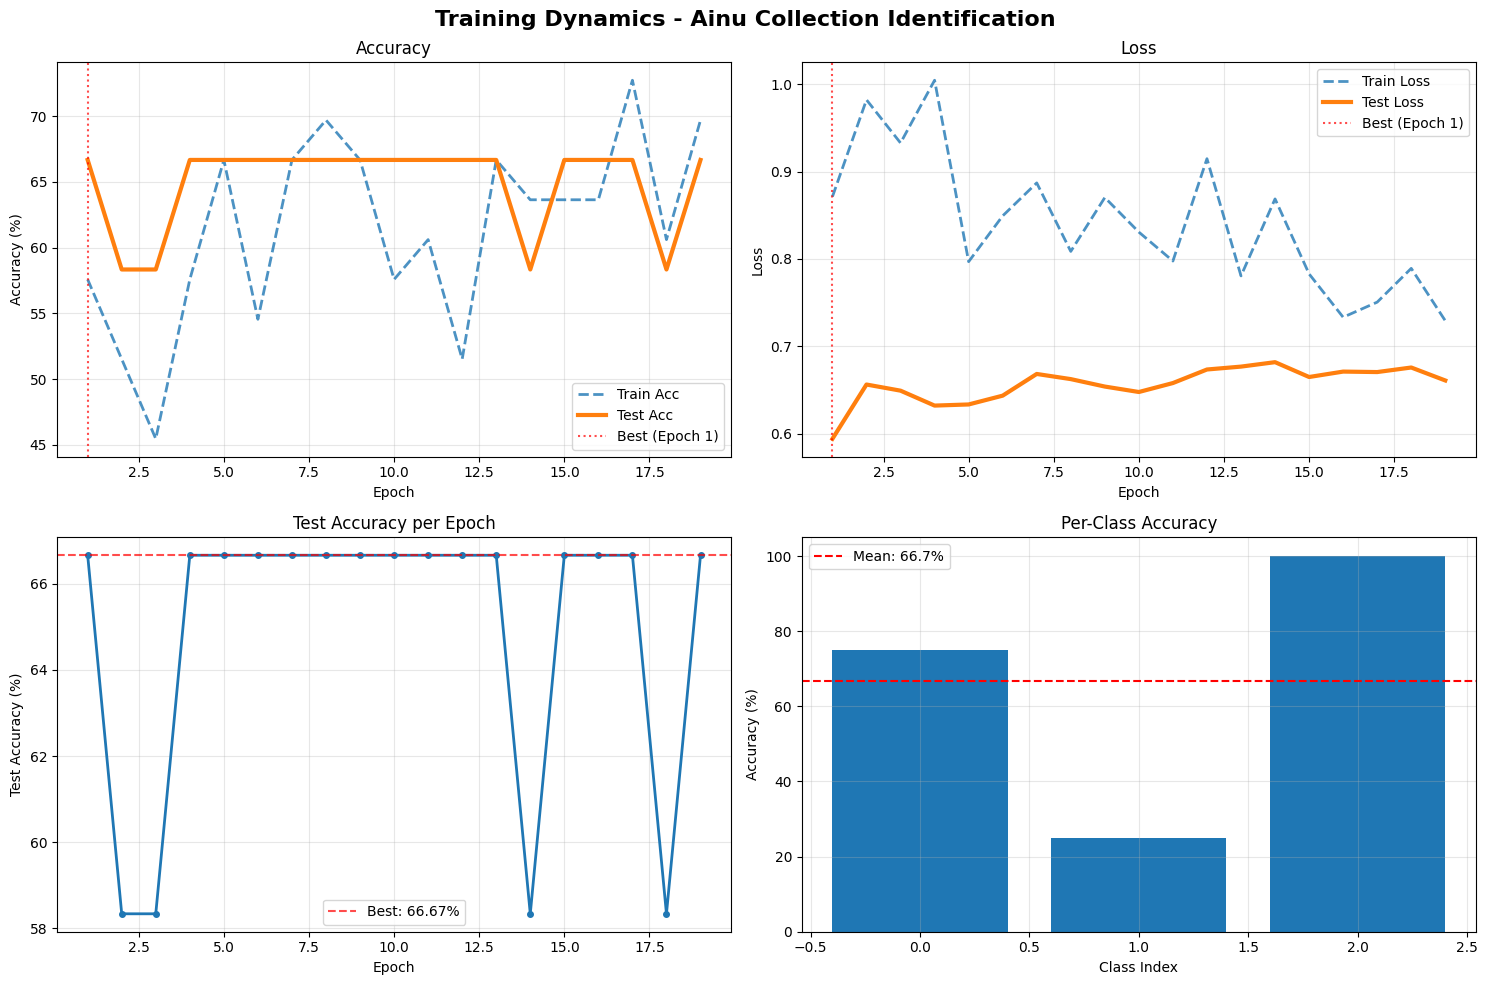


📈 CLASS-WISE PERFORMANCE (Collections):
------------------------------------------------------------
Average class accuracy: 66.67%
Standard deviation: 31.18%
Min class accuracy: 25.00%
Max class accuracy: 100.00%

Top 3 best collections:
  1. oda_ito_stories : 100.00%
  2. asai_take_stories : 75.00%
  3. kimura_kimi_stories : 25.00%

Top 3 most challenging collections:
  1. oda_ito_stories : 100.00%
  2. asai_take_stories : 75.00%
  3. kimura_kimi_stories : 25.00%


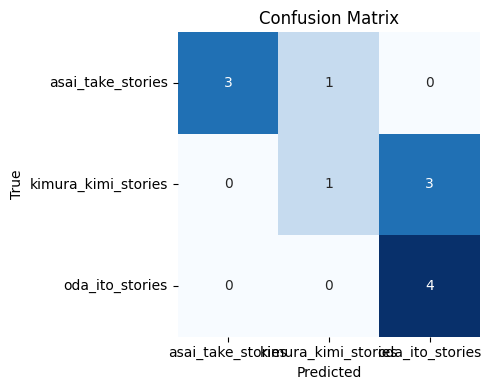


Classification Report:
                     precision    recall  f1-score   support

  asai_take_stories       1.00      0.75      0.86         4
kimura_kimi_stories       0.50      0.25      0.33         4
    oda_ito_stories       0.57      1.00      0.73         4

           accuracy                           0.67        12
          macro avg       0.69      0.67      0.64        12
       weighted avg       0.69      0.67      0.64        12


💾 Results saved to: ainu_cnn_results_20250912_160757.json


In [ ]:
# Simplified analysis for single model results (adapted for Ainu collections)
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


def analyze_single_model_results(results):
    """Analysis & visualization adapted for Ainu collection identification."""
    print("\n" + "="*80)
    print("AINU COLLECTION MODEL RESULTS ANALYSIS")
    print("="*80)

    # Basic performance summary
    print(f"🏆 Best Test Accuracy: {results['best_test_accuracy']:.2f}% (Epoch {results['best_epoch']})")
    print(f"📈 Final Test Accuracy: {results['final_test_accuracy']:.2f}%")
    first_test = results['test_accuracies'][0] if results['test_accuracies'] else float('nan')
    print(f"📊 Total Improvement: {results['final_test_accuracy'] - first_test:.2f}%")
    print(f"🎯 Final Training Accuracy: {results['train_accuracies'][-1]:.2f}%")
    print(f"⚖️ Overfitting Gap: {results['train_accuracies'][-1] - results['final_test_accuracy']:.2f}%")

    # Prepare epochs axis
    epochs_range = range(1, len(results['train_accuracies']) + 1)

    # Figure with 4 panels
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Dynamics - Ainu Collection Identification', fontsize=16, fontweight='bold')

    # 1. Accuracy curves
    ax1 = axes[0, 0]
    ax1.plot(epochs_range, results['train_accuracies'], '--', label='Train Acc', alpha=0.8, linewidth=2)
    ax1.plot(epochs_range, results['test_accuracies'], '-', label='Test Acc', linewidth=3)
    ax1.axvline(x=results['best_epoch'], color='red', linestyle=':', alpha=0.7,
                label=f'Best (Epoch {results["best_epoch"]})')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy (%)'); ax1.set_title('Accuracy'); ax1.legend(); ax1.grid(True, alpha=0.3)

    # 2. Loss curves
    ax2 = axes[0, 1]
    ax2.plot(epochs_range, results['train_losses'], '--', label='Train Loss', alpha=0.8, linewidth=2)
    ax2.plot(epochs_range, results['test_losses'], '-', label='Test Loss', linewidth=3)
    ax2.axvline(x=results['best_epoch'], color='red', linestyle=':', alpha=0.7,
                label=f'Best (Epoch {results["best_epoch"]})')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss'); ax2.set_title('Loss'); ax2.legend(); ax2.grid(True, alpha=0.3)

    # 3. Test accuracy progression
    ax3 = axes[1, 0]
    ax3.plot(epochs_range, results['test_accuracies'], 'o-', linewidth=2, markersize=4)
    ax3.axhline(y=results['best_test_accuracy'], color='red', linestyle='--', alpha=0.7,
                label=f'Best: {results['best_test_accuracy']:.2f}%')
    ax3.set_xlabel('Epoch'); ax3.set_ylabel('Test Accuracy (%)'); ax3.set_title('Test Accuracy per Epoch'); ax3.legend(); ax3.grid(True, alpha=0.3)

    # 4. Class accuracy distribution
    ax4 = axes[1, 1]
    class_acc_dict = results['final_class_accuracy']
    class_accuracies = list(class_acc_dict.values())
    ax4.bar(range(len(class_accuracies)), class_accuracies)
    ax4.axhline(np.mean(class_accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(class_accuracies):.1f}%')
    ax4.set_xlabel('Class Index'); ax4.set_ylabel('Accuracy (%)'); ax4.set_title('Per-Class Accuracy'); ax4.legend(); ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ainu_model_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Expanded class-wise stats
    print(f"\n📈 CLASS-WISE PERFORMANCE (Collections):")
    print("-" * 60)
    print(f"Average class accuracy: {np.mean(class_accuracies):.2f}%")
    print(f"Standard deviation: {np.std(class_accuracies):.2f}%")
    print(f"Min class accuracy: {np.min(class_accuracies):.2f}%")
    print(f"Max class accuracy: {np.max(class_accuracies):.2f}%")

    # Sort classes
    sorted_classes = sorted(class_acc_dict.items(), key=lambda x: x[1], reverse=True)
    idx_to_collection = results.get('idx_to_collection', {})
    top_k = min(5, len(sorted_classes))
    print(f"\nTop {top_k} best collections:")
    for i, (cid, acc) in enumerate(sorted_classes[:top_k]):
        print(f"  {i+1}. {idx_to_collection.get(cid, f'Class {cid}')} : {acc:.2f}%")

    print(f"\nTop {top_k} most challenging collections:")
    for i, (cid, acc) in enumerate(sorted_classes[-top_k:]):
        print(f"  {i+1}. {idx_to_collection.get(cid, f'Class {cid}')} : {acc:.2f}%")

    # Confusion matrix & classification report if we stored predictions
    if 'y_true' in results and 'y_pred' in results and results['y_true'] and results['y_pred']:
        y_true = np.array(results['y_true'])
        y_pred = np.array(results['y_pred'])
        labels = sorted(set(y_true) | set(y_pred))
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=[idx_to_collection.get(i, i) for i in labels],
                    yticklabels=[idx_to_collection.get(i, i) for i in labels])
        plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('ainu_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        print('\nClassification Report:')
        report = classification_report(y_true, y_pred, target_names=[idx_to_collection.get(i, str(i)) for i in labels], digits=2)
        print(report)
    else:
        print('\n(No y_true / y_pred stored; confusion matrix skipped.)')

    # Save detailed JSON
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    results_filename = f'ainu_cnn_results_{timestamp}.json'
    json_results = {
        'model_name': 'BestCNN',
        'best_test_accuracy': float(results['best_test_accuracy']),
        'best_epoch': int(results['best_epoch']),
        'final_test_accuracy': float(results['final_test_accuracy']),
        'train_accuracies': [float(x) for x in results['train_accuracies']],
        'test_accuracies': [float(x) for x in results['test_accuracies']],
        'train_losses': [float(x) for x in results['train_losses']],
        'test_losses': [float(x) for x in results['test_losses']],
        'final_class_accuracy': {str(k): float(v) for k, v in class_acc_dict.items()},
        'timestamp': timestamp
    }
    if 'y_true' in results and 'y_pred' in results:
        json_results['y_true'] = results['y_true']
        json_results['y_pred'] = results['y_pred']
        json_results['idx_to_collection'] = results.get('idx_to_collection', {})

    with open(results_filename, 'w') as f:
        json.dump(json_results, f, indent=2)
    print(f"\n💾 Results saved to: {results_filename}")
    return results

# Execute analysis
final_results = analyze_single_model_results(training_results)

In [ ]:
# 17. Inference Helper for Ainu Collection Prediction (updated for improvements)

def load_best_model(path='best_ainu_collection_model.pth'):
    if not os.path.exists(path) or model is None:
        print('[WARN] Model file not found or model undefined.')
        return None
    m = BestCNN(num_classes, in_channels=IN_CHANNELS)
    m.load_state_dict(torch.load(path, map_location=device))
    m.to(device).eval()
    return m

IDX_TO_COLLECTION = {v:k for k,v in collection_to_id.items()}

def _inference_preprocess(y, sr):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=TARGET_N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # pad/truncate to TARGET_FRAMES
    if mel_db.shape[1] > TARGET_FRAMES:
        mel_db = mel_db[:, :TARGET_FRAMES]
    elif mel_db.shape[1] < TARGET_FRAMES:
        mel_db = np.pad(mel_db, ((0,0),(0, TARGET_FRAMES - mel_db.shape[1])), mode='constant')
    # no random crop at inference; if training used crop < TARGET_FRAMES, we still feed full padded window
    if IMPROVE_CFG.get('global_norm') and GLOBAL_MEL_MEAN is not None:
        mel_db = (mel_db - GLOBAL_MEL_MEAN[:, None]) / (GLOBAL_MEL_STD[:, None] + 1e-6)
    else:
        mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)
    # delta stacking
    if IMPROVE_CFG.get('enable') and IMPROVE_CFG.get('use_delta'):
        delta = librosa.feature.delta(mel_db)
        chans = [mel_db, delta]
        if IMPROVE_CFG.get('use_delta_delta'):
            delta2 = librosa.feature.delta(mel_db, order=2)
            chans.append(delta2)
        arr = np.stack(chans, axis=0)
    else:
        arr = mel_db[None, ...]
    return arr.astype(np.float32)

def predict_collection(audio_path: str):
    if model is None:
        print('Model not initialized.')
        return None
    m = load_best_model()
    if m is None:
        return None
    try:
        y, sr = librosa.load(audio_path, sr=16000, mono=True)
        arr = _inference_preprocess(y, sr)  # (C,M,T)
        m_in = torch.from_numpy(arr).unsqueeze(0).float().to(device)
        with torch.no_grad():
            logits = m(m_in)
            pred_id = int(torch.argmax(logits, dim=1).item())
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        return {'prediction': IDX_TO_COLLECTION.get(pred_id, 'UNKNOWN'),
                'probs': {IDX_TO_COLLECTION.get(i, str(i)): float(p) for i,p in enumerate(probs)}}
    except Exception as e:
        print('[ERR] prediction failed', e)
        return None

# Example (uncomment and set path):
# print(predict_collection('/path/to/ainu_clip.wav'))

In [ ]:
# 18. (Optional) Legacy Analysis Block - retained for reference but not Ainu-adapted
print('Legacy analysis cell retained (references Japanese singer context). Consider adapting or removing.')

Legacy analysis cell retained (references Japanese singer context). Consider adapting or removing.
